In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import quad
from matplotlib.animation import FuncAnimation, PillowWriter
from scipy.spatial import cKDTree
import time as t

In [2]:
tex_fonts = {
    "text.usetex": True,
    "font.family": "serif",
    "axes.labelsize": 14,
    "font.size": 14,
    "legend.fontsize": 12,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14
}
plt.rcParams.update(tex_fonts)

# Defining the project

Goal: To create a simple simulation of a dark matter halo as a collection of dark matter point particles that are initially NFW, and let them evolve with interactions to show how the density profile and shape are affected as a function of time. 
1. Create a set of randomized point particles distributed according to an NFW density profile 
2. Evolve the particles given a gravitational potential and randomized initial velocities 
3. Give the particles some probability of interacting that depends on the density and leads to isotropization 
4. Calculate the density and shape as a function of time
5. Create a simple animation to illustrate the effects of self-interacting dark matter

Add gravitational softening 

# Setting up the simualtion 

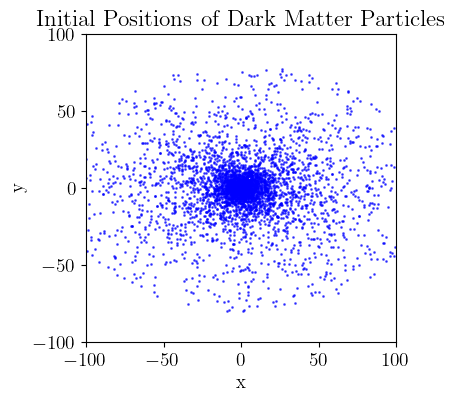

In [3]:
num_particles = 5000

# function for the NFW profile 
def rho_NFW(r):
    # rho0 and rs set to 1 for simplicity
    return 1 / (r * (1 + r)**2)

# define the CDF of the NFW profile
def cdf_NFW(r):
    result, _ = quad(lambda r_prime: 4 * np.pi * r_prime**2 * rho_NFW(r_prime), 0, r)
    return result

# Vectorize the CDF function
cdf_NFW_vec = np.vectorize(cdf_NFW)

# Define radii for the CDF calculation
radii = np.geomspace(0.01, 100, 1000)

# Calculate the CDF values
cdf_values = cdf_NFW_vec(radii)

# Normalize the CDF values
cdf_values /= cdf_values[-1]

# Inverse transform sampling
def inverse_transform_sampling(cdf, size=1):
    random_values = np.random.rand(size)
    return np.interp(random_values, cdf, radii)

# Generate random samples
sampled_radii = inverse_transform_sampling(cdf_values, num_particles)

# Convert radii to x and y coordinates assuming a random angle distribution
angles = np.random.uniform(0, 2 * np.pi, num_particles)
x_positions = sampled_radii * np.cos(angles) * 1.2
y_positions = sampled_radii * np.sin(angles) * 0.8

# Plot the sampled particle positions
plt.figure(figsize=(4, 4))
plt.scatter(x_positions, y_positions, s=1, alpha=0.6, color='b')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-100, 100)
plt.ylim(-100, 100)
plt.title('Initial Positions of Dark Matter Particles')
plt.show()

# Setting up the simulation

In [4]:
## Gravitational potential 
G = 1.0  # G newton set to 1 for simplicity
epsilon = 0.1  # Softening length

# NFW potential
def nfw_potential(r):
    return -4 * np.pi * G * np.log(1 + r) / r

# # Define the acceleration computation from the potential
def compute_acceleration(x, y):
    r = np.sqrt(x**2 + y**2)
    ax = np.zeros_like(x)
    ay = np.zeros_like(y)
    non_zero_indices = r > 0
    r_non_zero = r[non_zero_indices]
    ax[non_zero_indices] = -x[non_zero_indices] * (4 * np.pi * G / r_non_zero**2) * (1 / r_non_zero - 1 / (1 + r_non_zero))
    ay[non_zero_indices] = -y[non_zero_indices] * (4 * np.pi * G / r_non_zero**2) * (1 / r_non_zero - 1 / (1 + r_non_zero))
    return ax, ay

# Define the acceleration computation from the softened potential
# def compute_acceleration(x, y):
#     r = np.sqrt(x**2 + y**2)
#     r_soft = np.sqrt(r**2 + epsilon**2)
#     ax = np.zeros_like(x)
#     ay = np.zeros_like(y)
#     non_zero_indices = r > 0
#     r_non_zero = r[non_zero_indices]
#     r_soft_non_zero = r_soft[non_zero_indices]
#     ax[non_zero_indices] = -x[non_zero_indices] * (4 * np.pi * G / r_soft_non_zero**3) * (1 - 1 / (1 + r_soft_non_zero))
#     ay[non_zero_indices] = -y[non_zero_indices] * (4 * np.pi * G / r_soft_non_zero**3) * (1 - 1 / (1 + r_soft_non_zero))
#     return ax, ay

# Initialize positions and velocities (using the results from your previous steps)
sigma_v = 1.0  # Normalized units

# Maxwell-Boltzmann distribution for the velocities
initial_velocities_x = np.random.normal(0, sigma_v, num_particles)
initial_velocities_y = np.random.normal(0, sigma_v, num_particles)

# Define a simple collision probability model
def collision_probability(density, cross_section=10.0):
    return density * cross_section

# Function to handle collisions and conserve momentum
def handle_collisions(x, y, vx, vy, density, x_bins, y_bins):
    positions = np.vstack((x, y)).T
    tree = cKDTree(positions)
    pairs = tree.query_pairs(r=1.0)  # Search for pairs within a distance of 1.0

    for i, j in pairs:
        x_idx_i = np.digitize(x[i], x_bins) - 1
        y_idx_i = np.digitize(y[i], y_bins) - 1
        x_idx_j = np.digitize(x[j], x_bins) - 1
        y_idx_j = np.digitize(y[j], y_bins) - 1

        if 0 <= x_idx_i < grid_size and 0 <= y_idx_i < grid_size and 0 <= x_idx_j < grid_size and 0 <= y_idx_j < grid_size:
            local_density_i = density[x_idx_i, y_idx_i]
            local_density_j = density[x_idx_j, y_idx_j]
            prob_i = collision_probability(local_density_i)
            prob_j = collision_probability(local_density_j)

            if np.random.rand() < prob_i * dt and np.random.rand() < prob_j * dt:
                # Conservation of momentum for a simple elastic collision
                vx_i, vy_i = vx[i], vy[i]
                vx_j, vy_j = vx[j], vy[j]
                vx[i] = vx_j
                vy[i] = vy_j
                vx[j] = vx_i
                vy[j] = vy_i

In [19]:
# Time step and number of steps
dt = 0.01
num_steps = 4000

# Arrays to store positions and velocities over time
positions_x = np.zeros((num_steps, num_particles))
positions_y = np.zeros((num_steps, num_particles))
velocities_x_all = np.zeros((num_steps, num_particles))
velocities_y_all = np.zeros((num_steps, num_particles))

# Set initial positions and velocities
positions_x[0] = x_positions
positions_y[0] = y_positions
velocities_x_all[0] = initial_velocities_x
velocities_y_all[0] = initial_velocities_y

# Define the local density function using the NFW profile
def local_density(x, y):
    r = np.sqrt(x**2 + y**2)
    return rho_NFW(r)
# Define grid for density calculation
# grid_size = 100
# x_min, x_max = -100, 100
# y_min, y_max = -100, 100
# x_bins = np.linspace(x_min, x_max, grid_size + 1)
# y_bins = np.linspace(y_min, y_max, grid_size + 1)

def calculate_density(positions_x, positions_y, x_bins, y_bins):
    density, _, _ = np.histogram2d(positions_x, positions_y, bins=[x_bins, y_bins])
    density /= (np.diff(x_bins)[0] * np.diff(y_bins)[0])  # Normalize by the area of each cell
    return density

# Time evolution loop using Velocity Verlet integration
for t in range(1, num_steps):
    # Compute current acceleration
    ax, ay = compute_acceleration(positions_x[t-1], positions_y[t-1])
    
    # Update positions
    positions_x[t] = positions_x[t-1] + velocities_x_all[t-1] * dt + 0.5 * ax * dt**2
    positions_y[t] = positions_y[t-1] + velocities_y_all[t-1] * dt + 0.5 * ay * dt**2
    
    # Compute new acceleration
    ax_new, ay_new = compute_acceleration(positions_x[t], positions_y[t])
    
    # Update velocities
    velocities_x_all[t] = velocities_x_all[t-1] + 0.5 * (ax + ax_new) * dt
    velocities_y_all[t] = velocities_y_all[t-1] + 0.5 * (ay + ay_new) * dt
    
    # Apply collisions based on local density
    for i in range(num_particles):
        density = local_density(positions_x[t][i], positions_y[t][i])
        prob = collision_probability(density)
        if np.random.rand() < prob * dt:  # Collision occurs
            # Simple model: randomize velocity direction while keeping the same speed
            speed = np.sqrt(velocities_x_all[t][i]**2 + velocities_y_all[t][i]**2)
            angle = np.random.uniform(0, 2 * np.pi)
            velocities_x_all[t][i] = speed * np.cos(angle)
            velocities_y_all[t][i] = speed * np.sin(angle)

# # Time evolution loop using Velocity Verlet integration
# for t in range(1, num_steps):
#     # Compute current acceleration
#     ax, ay = compute_acceleration(positions_x[t-1], positions_y[t-1])
    
#     # Update positions
#     positions_x[t] = positions_x[t-1] + velocities_x_all[t-1] * dt + 0.5 * ax * dt**2
#     positions_y[t] = positions_y[t-1] + velocities_y_all[t-1] * dt + 0.5 * ay * dt**2
    
#     # Compute new acceleration
#     ax_new, ay_new = compute_acceleration(positions_x[t], positions_y[t])
    
#     # Update velocities
#     velocities_x_all[t] = velocities_x_all[t-1] + 0.5 * (ax + ax_new) * dt
#     velocities_y_all[t] = velocities_y_all[t-1] + 0.5 * (ay + ay_new) * dt

#     # Update density every 10 time steps
#     if t % 100 == 0 or t == 1: # calculate density initially and every 100 steps
#         print(f"Calculating density at time step {t}")
#         density_grid = calculate_density(positions_x[t], positions_y[t], x_bins, y_bins)
    
#     # Handle collisions with momentum conservation
#     handle_collisions(positions_x[t], positions_y[t], velocities_x_all[t], velocities_y_all[t], density_grid, x_bins, y_bins)

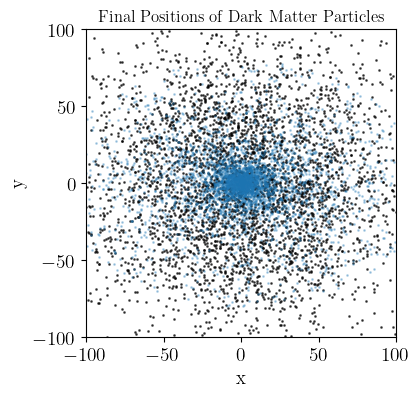

In [20]:
# Plot the final positions of the particles
plt.figure(figsize=(4, 4))
plt.scatter(positions_x[-1], positions_y[-1],s=1, alpha=0.6, color='k')
plt.scatter(x_positions, y_positions, s=1, alpha=0.3, color='C0')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-100, 100)
plt.ylim(-100, 100)
plt.title('Final Positions of Dark Matter Particles', fontsize=12)
plt.show()

In [58]:
# # Create an animation of the particle evolution
# fig, ax = plt.subplots(figsize=(4, 4))
# scat = ax.scatter(positions_x[0], positions_y[0], s=1, alpha=0.6)
# ax.set_xlim(-100, 100)
# ax.set_ylim(-100, 100)

# def update(frame):
#     scat.set_offsets(np.c_[positions_x[frame], positions_y[frame]])
#     return scat,

# ani = FuncAnimation(fig, update, frames=num_steps, interval=20, blit=True)
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('Particle Evolution Over Time')
# plt.grid(True)
# plt.axis('equal')

# # Save the animation as a GIF
# ani.save('particle_evolution.gif', writer=PillowWriter(fps=20))

# plt.show()

# Check the density profiles

In [7]:
# Define fixed spherical shells from 0 to 100
r_bins = np.linspace(0, 100, 51)  # 50 bins from 0 to 100
r_bin_centers = 0.5 * (r_bins[:-1] + r_bins[1:])

# Calculate the volume of each spherical shell
volumes = (4/3) * np.pi * (r_bins[1:]**3 - r_bins[:-1]**3)

def calculate_density_profile(positions_x, positions_y, num_bins=50):

    # Calculate the radial distance for each particle
    radii = np.sqrt(positions_x**2 + positions_y**2)

    # Count the number of particles in each bin
    particle_counts, _ = np.histogram(radii, bins=r_bins)

    # Calculate the density
    density = particle_counts / volumes

    # Calculate the NFW density profile for comparison
    nfw_density = 100 * rho_NFW(r_bin_centers)

    # Plot the density profile
    plt.figure(figsize=(4, 4))
    plt.plot(r_bin_centers, density, label='Simulated Density')
    plt.plot(r_bin_centers, nfw_density, label='NFW Profile', linestyle='--')
    plt.xlabel('Radius')
    plt.ylabel('Density')
    plt.yscale('log')  
    plt.xscale('log')
    # plt.xlim(1,100)
    plt.title('Density as a Function of Radius')
    plt.legend()
    plt.grid(True)
    plt.show()


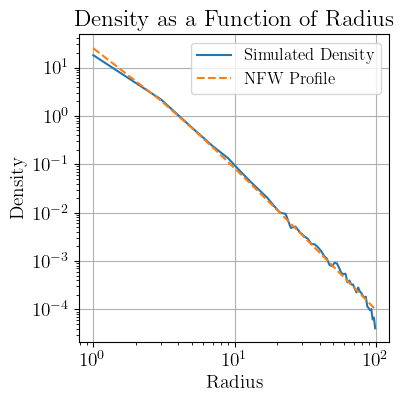

In [8]:
# plot the density profile for the starting positions 
calculate_density_profile(x_positions, y_positions)

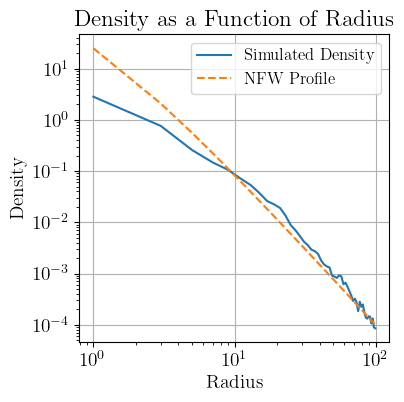

In [9]:
# plot the final density profile
calculate_density_profile(positions_x[-1], positions_y[-1])

(-100.0, 100.0)

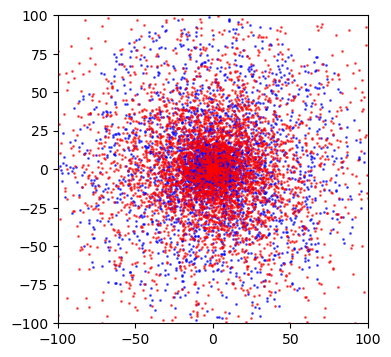

In [43]:
plt.figure(figsize=(4, 4))
plt.scatter(x_positions, y_positions, s=1, alpha=0.6, color='b')
plt.scatter(positions_x[-1], positions_y[-1], s=1, alpha=0.6, color='r')
plt.xlim(-100, 100)
plt.ylim(-100, 100)

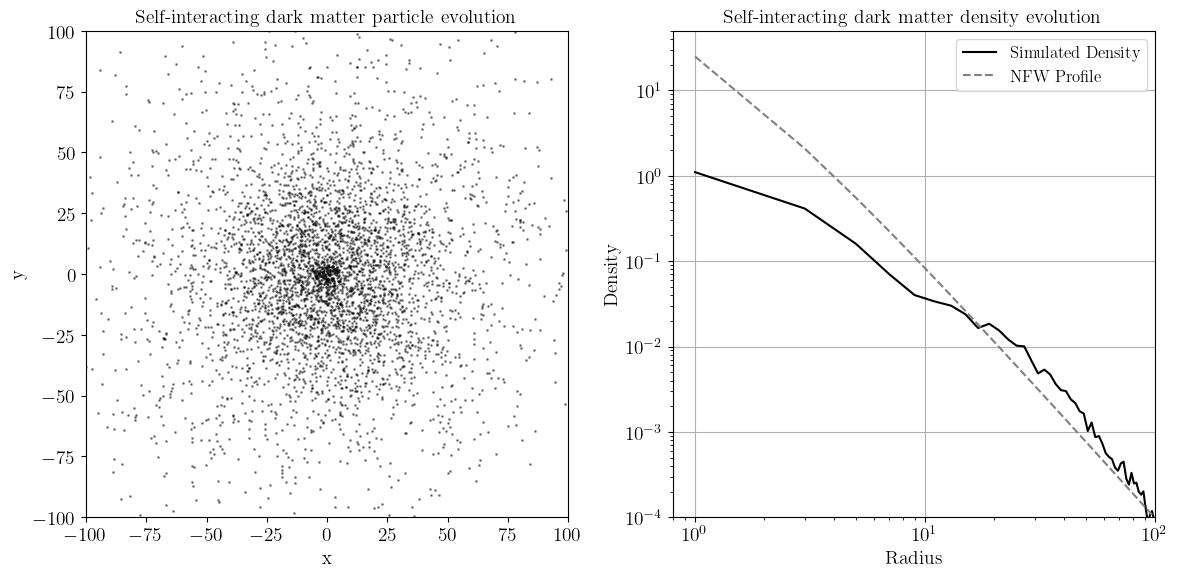

In [74]:
# Define fixed spherical shells from 0 to 100
r_bins = np.linspace(0, 100, 51)  # 50 bins from 0 to 100
r_bin_centers = 0.5 * (r_bins[:-1] + r_bins[1:])

# Calculate the volume of each spherical shell
volumes = (4/3) * np.pi * (r_bins[1:]**3 - r_bins[:-1]**3)

# Define the density profile calculation function with fixed bins
def calculate_density_profile(positions_x, positions_y, r_bins, volumes):
    # Calculate the radial distance for each particle
    radii = np.sqrt(positions_x**2 + positions_y**2)

    # Count the number of particles in each bin
    particle_counts, _ = np.histogram(radii, bins=r_bins)

    # Calculate the density
    density = particle_counts / volumes

    return r_bin_centers, density

# Create an animation of the particle evolution and density profile
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
scat = ax1.scatter(positions_x[0], positions_y[0], marker='o',s=1, alpha=0.4, color='k')
ax1.set_xlim(-100, 100)
ax1.set_ylim(-100, 100)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Self-interacting dark matter particle evolution', fontsize=14)

line_sim, = ax2.plot([], [], label='Simulated Density', color='k')
line_nfw, = ax2.plot([], [], label='NFW Profile', linestyle='--', color='grey')
ax2.set_xlabel('Radius')
ax2.set_ylabel('Density')
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlim(0.8, 100)
ax2.set_ylim(1e-4, 50)
ax2.set_title('Self-interacting dark matter density evolution', fontsize=14)
ax2.legend()
ax2.grid(True)

def update(frame):
    scat.set_offsets(np.c_[positions_x[frame], positions_y[frame]])
    
    r_bin_centers, density = calculate_density_profile(positions_x[frame], positions_y[frame], r_bins, volumes)
    nfw_density = 100 * rho_NFW(r_bin_centers)

    line_sim.set_data(r_bin_centers, density)
    line_nfw.set_data(r_bin_centers, nfw_density)

    return scat, line_sim, line_nfw

ani = FuncAnimation(fig, update, frames=num_steps, interval=20, blit=True)
plt.tight_layout()

# Save the animation as a GIF
ani.save('particle_evolution_with_density.gif', writer=PillowWriter(fps=50))

plt.show()

# Calcualting the shape

In [10]:
def calculate_axial_ratio(positions_x, positions_y, r_bins):
    """
    Calculate the axial ratio (semi-major to semi-minor axis) for each radial shell.

    Parameters:
    positions_x (numpy.ndarray): x-coordinates of the particles.
    positions_y (numpy.ndarray): y-coordinates of the particles.
    r_bins (numpy.ndarray): Edges of the radial bins.

    Returns:
    r_bin_centers (numpy.ndarray): Centers of the radial bins.
    axial_ratios (numpy.ndarray): Axial ratios for each radial bin.
    """
    r_bin_centers = 0.5 * (r_bins[:-1] + r_bins[1:])
    axial_ratios = []

    for i in range(len(r_bins) - 1):
        mask = (np.sqrt(positions_x**2 + positions_y**2) >= r_bins[i]) & (np.sqrt(positions_x**2 + positions_y**2) < r_bins[i+1])
        if np.sum(mask) > 0:
            x_bin = positions_x[mask]
            y_bin = positions_y[mask]
            cov = np.cov(x_bin, y_bin)
            eigvals, _ = np.linalg.eig(cov)
            semi_major = np.sqrt(np.max(eigvals))
            semi_minor = np.sqrt(np.min(eigvals))
            axial_ratios.append(semi_major / semi_minor)
        else:
            axial_ratios.append(np.nan)

    return r_bin_centers, np.array(axial_ratios)

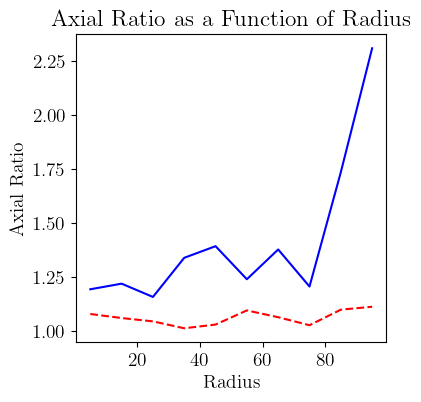

In [21]:
r_bins = np.linspace(0, 100, 11)
# Calculate axial ratios
r_bin_centers, axial_ratios = calculate_axial_ratio(positions_x[0], positions_y[0], r_bins)
r_bin_centers_end, axial_ratios_end = calculate_axial_ratio(positions_x[-1], positions_y[-1], r_bins)

# Plot axial ratios
plt.figure(figsize=(4, 4))
plt.plot(r_bin_centers, axial_ratios, color='b')
plt.plot(r_bin_centers_end, axial_ratios_end, linestyle='--', color='r')
plt.xlabel('Radius')
plt.ylabel('Axial Ratio')
plt.title('Axial Ratio as a Function of Radius')
plt.show()

# Calculate the shape q

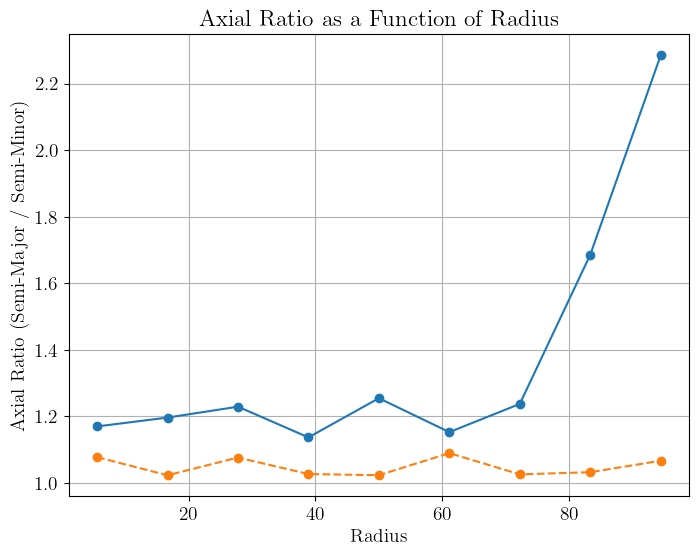

In [88]:

def calculate_shape_profile(positions_x, positions_y, r_bins):
    """
    Calculate the axial ratio (semi-major to semi-minor axis) for each radial shell.

    Parameters:
    positions_x (numpy.ndarray): x-coordinates of the particles.
    positions_y (numpy.ndarray): y-coordinates of the particles.
    r_bins (numpy.ndarray): Edges of the radial bins.

    Returns:
    r_bin_centers (numpy.ndarray): Centers of the radial bins.
    axial_ratios (numpy.ndarray): Axial ratios for each radial bin.
    """
    r_bin_centers = 0.5 * (r_bins[:-1] + r_bins[1:])
    axial_ratios = []

    for i in range(len(r_bins) - 1):
        mask = (np.sqrt(positions_x**2 + positions_y**2) >= r_bins[i]) & (np.sqrt(positions_x**2 + positions_y**2) < r_bins[i+1])
        if np.sum(mask) > 0:
            x_bin = positions_x[mask]
            y_bin = positions_y[mask]
            cov = np.cov(x_bin, y_bin)
            eigvals, _ = np.linalg.eig(cov)
            semi_major = np.sqrt(np.max(eigvals))
            semi_minor = np.sqrt(np.min(eigvals))
            axial_ratios.append(semi_major / semi_minor)
        else:
            axial_ratios.append(np.nan)

    return r_bin_centers, np.array(axial_ratios)

# Define fixed spherical shells from 0 to 100
r_bins = np.linspace(0, 100, 10)  # 50 bins from 0 to 100

# Example usage with the final positions from the simulation
r_bin_centers, axial_ratios = calculate_shape_profile(positions_x[0], positions_y[0], r_bins)
r_bin_centers_l, axial_ratios_l = calculate_shape_profile(positions_x[-1], positions_y[-1], r_bins)

# Plot the axial ratios
plt.figure(figsize=(8, 6))
plt.plot(r_bin_centers, axial_ratios, marker='o', linestyle='-')
plt.plot(r_bin_centers_l, axial_ratios_l, marker='o', linestyle='--')
plt.xlabel('Radius')
plt.ylabel('Axial Ratio (Semi-Major / Semi-Minor)')
plt.title('Axial Ratio as a Function of Radius')
plt.grid(True)
plt.show()

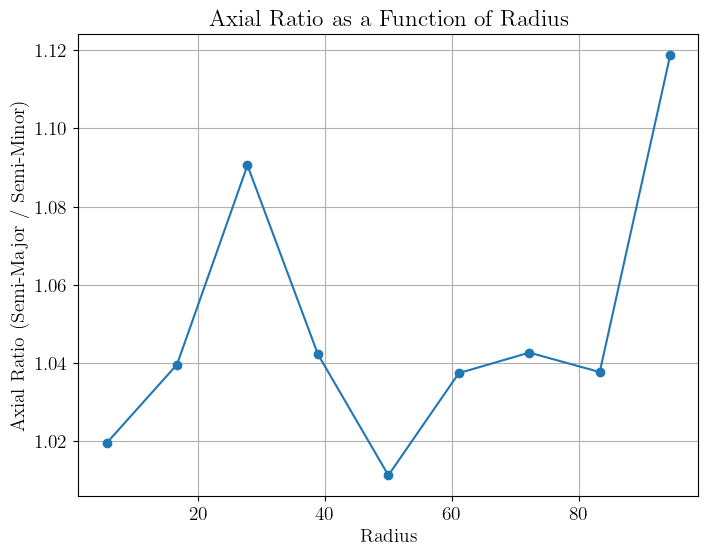

In [75]:
num_particles = 5000
sampled_radii = inverse_transform_sampling(cdf_values, num_particles)
theta = np.arccos(2 * np.random.rand(num_particles) - 1)
phi = np.random.uniform(0, 2 * np.pi, num_particles)
x_positions_c = sampled_radii * np.sin(theta) * np.cos(phi)
y_positions_c = sampled_radii * np.sin(theta) * np.sin(phi)
z_positions = sampled_radii * np.cos(theta)
y_positions_c = z_positions  # Use x and y for 2D simplification

# Calculate axial ratios
r_bin_centers, axial_ratios = calculate_axial_ratio(x_positions_c, y_positions_c, r_bins)

# Plot the axial ratios
plt.figure(figsize=(8, 6))
plt.plot(r_bin_centers, axial_ratios, marker='o', linestyle='-')
plt.xlabel('Radius')
plt.ylabel('Axial Ratio (Semi-Major / Semi-Minor)')
plt.title('Axial Ratio as a Function of Radius')
plt.grid(True)
plt.show()

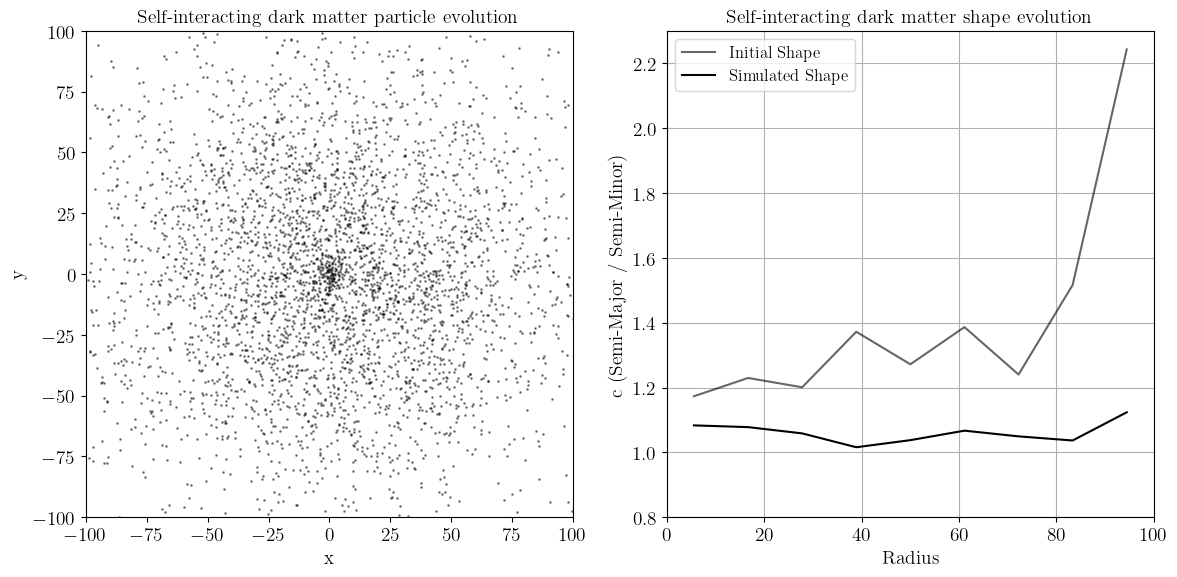

In [22]:
# Define fixed spherical shells from 0 to 100
r_bins = np.linspace(0, 100, 10)  # 50 bins from 0 to 100

# Create an animation of the particle evolution and density profile
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
scat = ax1.scatter(positions_x[0], positions_y[0], marker='o',s=1, alpha=0.4, color='k')
ax1.set_xlim(-100, 100)
ax1.set_ylim(-100, 100)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Self-interacting dark matter particle evolution', fontsize=14)

r_bin_centers1, shape1 = calculate_axial_ratio(positions_x[0], positions_y[0], r_bins)
ax2.plot(r_bin_centers1, shape1, label='Initial Shape', color='k', linestyle='-', alpha=0.6)
line_sim, = ax2.plot([], [], label='Simulated Shape', color='k')
ax2.set_xlabel('Radius')
ax2.set_ylabel('c (Semi-Major / Semi-Minor)')
# ax2.set_yscale('log')
# ax2.set_xscale('log')
ax2.set_xlim(0, 100)
ax2.set_ylim(0.8, 2.3)
ax2.set_title('Self-interacting dark matter shape evolution', fontsize=14)
ax2.legend(loc='upper left')
ax2.grid(True)

def update(frame):
    scat.set_offsets(np.c_[positions_x[frame], positions_y[frame]])
    
    r_bin_centers, shape = calculate_axial_ratio(positions_x[frame], positions_y[frame], r_bins)

    line_sim.set_data(r_bin_centers, shape)

    return scat, line_sim

ani = FuncAnimation(fig, update, frames=num_steps, interval=20, blit=True)
plt.tight_layout()

# Save the animation as a GIF
ani.save('particle_evolution_with_shape.gif', writer=PillowWriter(fps=50))

plt.show()